In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import nepal_figs
import etas_analyzer

failed while loading urllib and/or urllib. maybe python 3.x?
failed while loading urllib and/or urllib. maybe python 3.x?


In [3]:
#aa=nepal_figs.toy_gs_roc()


### Fixing and revising analyze_etas_roc_geospatial() function...
( from etas_analyzer.py)

In [4]:
diagnostic=True
etas_fc=None
etas_test=None
do_log=True
#do_log=False

In [5]:
#etas_test.make_etas()

begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog.
etas_prams:  {'lats': [23.175, 33.175], 'b1': 1.0, 'do_recarray': True, 'fit_factor': 1.5, 'd_lambda': 1.76, 'mc': 3.5, 'dmstar': 1.0, 'd_tau': 2.28, 'D_fract': 1.5, 'lons': [79.698, 89.698], 'incat': None, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'b2': 1.5, 'q': 1.5, 'p': 1.1}
data handle fetched...
 no file.
R:  <multiprocessing.pool.ApplyResult object at 0x7f43228cebe0>


/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1696: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof


results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 1240], None)
make_etas():
etas_mpp worker xyz_range:  [0, 10000]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1240], [0, 10000])
begin make_etas_rtree()
now gather sub-arrays...
len(local_lattice_dict):  10000
Indices initiated. begin ETAS ::  [0, 1240]
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 1240])
ETAS complete.
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2010-09-05 00:00:00+00:00
fetch and process catalog.
etas_prams:  {'lats': [23.175, 33.175], 'b1': 1.0, 'do_recarray': True, 'fit_factor': 1.5, 'd_lambda': 1.76, 'mc': 3.5, 'dmstar': 1.0, 'd_tau': 2.28, 'D_fract': 1.5, 'lons': [79.698, 89

/home/myoder/Documents/Research/yoder/globalETAS/globalETAS.py:1696: RuntimeWarning: divide by zero encountered in true_divide
  cov = numpy.dot(numpy.array(list(zip(*cat_prime))),numpy.array(cat_prime))/n_dof


R:  <multiprocessing.pool.ApplyResult object at 0x7f43228ced30>
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 147], None)
etas_mpp worker xyz_range:  [0, 10000]
begin globalETAS.__init()__
Overriding t0 for ETAS calculations. using catalog start, t0 = t_now - catlen (1825.000000) = 2010-09-05 00:00:00+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 147], [0, 10000])
begin make_etas_rtree()
now gather sub-arrays...
len(local_lattice_dict):  10000
Indices initiated. begin ETAS ::  [0, 147]
finished calculateing ETAS (rtree). wrap up in recarray and return.
etas complete (from mpp_rtree run() loop); now pipe back([0, 147])
shapes:  (100, 100) (100, 100)


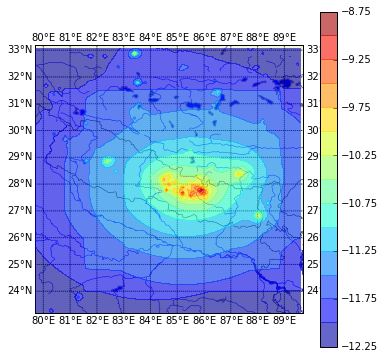

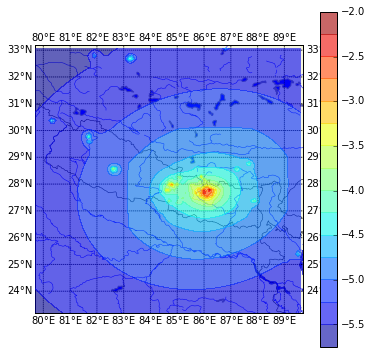

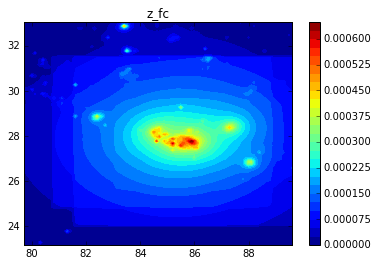

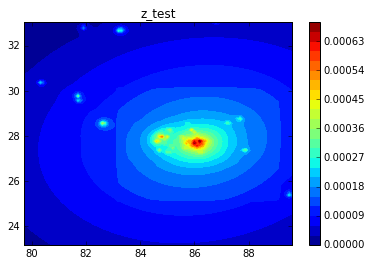

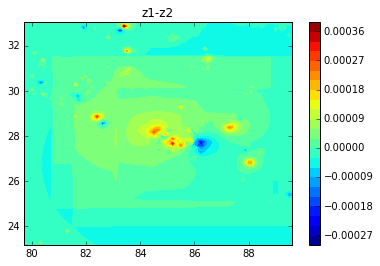

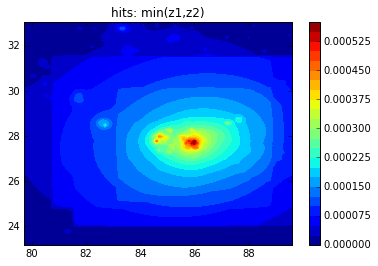

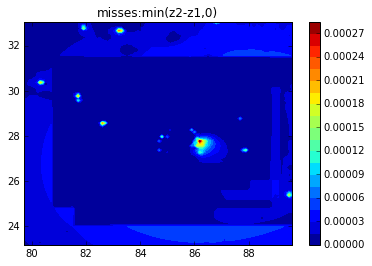

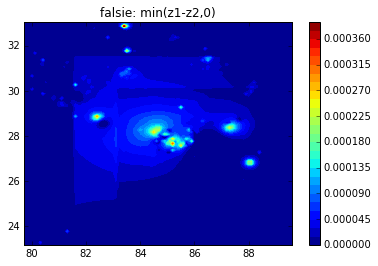

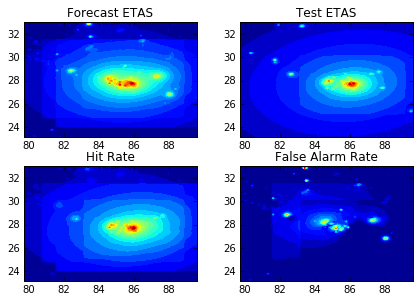

In [6]:
#def analyze_etas_roc_geospatial(etas_fc=None, etas_test=None, do_log=True, diagnostic=False):
from etas_analyzer import *
if True:
	
	# do_log should pretty much always be True.
	# this script draws a bunch of geospatial ROC figures. we'll use this script to draw a quad-figure with
	# z_fc, z_test, hits, falsies.
	#
	if etas_fc   == None: etas_fc   = get_nepal_etas_fc(n_procs=2*mpp.cpu_count())
	if etas_test == None: etas_test = get_nepal_etas_test(n_procs=2*mpp.cpu_count())
	#
	f_quad = plt.figure(42)
	plt.clf()
	ax0 = f_quad.add_axes([.05, .05, .4, .4])
	ax1 = f_quad.add_axes([.05, .55, .4, .4], sharex=ax0, sharey=ax0)
	ax2 = f_quad.add_axes([.55, .05, .4, .4], sharex=ax0, sharey=ax0)
	ax3 = f_quad.add_axes([.55, .55, .4, .4], sharex=ax0, sharey=ax0)		
	#
	# what we really want to do here is to calc_etas() (or whatever we call it). we do a full on _contour_map() so we can look at it.
	# in the end, to do the gs_roc, we just need the ETAS xyz array.
	etas_fc.make_etas_contour_map(fignum=0)
	etas_test.make_etas()
	etas_test.make_etas_contour_map(fignum=1)
	#
	lon_vals = sorted(list(set(etas_fc.ETAS_array['x'])))
	lat_vals = sorted(list(set(etas_fc.ETAS_array['y'])))
	#
	# we need normalization here...
	# ... and we need to think a bit more about what we mean by normalize. here, we just shift the values to be equal. do
	# we also want to normailze their range?
	z_fc_norm = etas_fc.ETAS_array['z'].copy()
	z_test_norm = etas_test.ETAS_array['z'].copy()
	#
	if do_log:
		z_fc_norm   = numpy.log10(z_fc_norm)
		z_test_norm = numpy.log10(z_test_norm)
	#
	z_fc_norm -= min(z_fc_norm)
	z_test_norm -= min(z_test_norm)
	#
	norm_fc   = sum(z_fc_norm)
	norm_test = sum(z_test_norm)
	#
	z_fc_norm /= norm_fc
	z_test_norm /= norm_test
	#
	z1 = z_fc_norm
	z2 = z_test_norm
	#
	#
	# [z1, z2, diff, h, m, f(predicted, didn't happen)
	#diffs = [[z1, z2, z1-z2, max(z1, z2), -min(z1-z2,0.), max(z1-z2,0.)] for z1,z2 in zip(z_fc_norm, z_test_norm)] 
	# hits: accurately predicted; min(z1,z2)
	# misses: prediction deficite, or excess events: min(z2-z1,0.)
	# falsie: excess prediction: min(z1-z2,0.)
	# then rates: H = hits/sum(z2), F =falsies/sum(z1)
	#diffs = [[z1, z2, z1-z2, min(z1, z2), max(z2-z1,0.), max(z1-z2, 0.)] for z1,z2 in zip(z_fc_norm, z_test_norm)]
	#
	# so we can test this properly, we'll want to move diffs offline to a function call (eventually)...
	
	#diffs = [[z1, z2, z1-z2, min(z1, z2), max(z2-z1,0.), max(z1-z2, 0.)] for z1,z2 in zip(z1, z2)]
	diffs = get_gs_diffs(z1,z2)
	diffs_lbls = ['z_fc', 'z_test', 'z1-z2', 'hits: min(z1,z2)','misses:min(z2-z1,0)', 'falsie: min(z1-z2,0)']
	diffs_lbl_basic = ['z_fc', 'z_test', 'z1-z2', 'hits','misses', 'falsie']
	#

	# to plot contours, we'll want to use the shape from: etas.lattice_sites.shape
	#
	sh1 = etas_fc.lattice_sites.shape
	sh2 = etas_test.lattice_sites.shape
	#
	print('shapes: ', sh1, sh2)
	#
	zs_diff, h, m, f = list(zip(*diffs))[2:]
	#
	# and ROC bits:
	H = sum(h)/sum(z2)
	F = sum(f)/sum(z1)
	#
	#for z in [zs_diff, h, m, f]:
	# plot the varous roc_gs contous (z1, z2, z2-z2, hits, etc.)
	for j,z in enumerate(list(zip(*diffs))):
		plt.figure(j+2)
		plt.clf()
		#
		zz=numpy.array(z)
		zz.shape=sh1
		#plt.contourf(list(set(etas_fc.ETAS_array['x'])), list(set(etas_fc.ETAS_array['y'])), zz, 25)
		#plt.contourf(numpy.log10(zz), 25)
		plt.contourf(lon_vals, lat_vals, zz, 25)
		plt.title(diffs_lbls[j])
		plt.colorbar()
		#
		# ... and make our quad-plot too:
		if j==0:
			ax1.contourf(lon_vals, lat_vals, zz, 25)
			ax1.set_title('Forecast ETAS')
			#ax1.colorbar()
		if j==1:
			ax3.contourf(lon_vals, lat_vals, zz, 25)
			ax3.set_title('Test ETAS')
			#ax3.colorbar()
		if j==3:
			ax0.contourf(lon_vals, lat_vals, zz, 25)
			ax0.set_title('Hit Rate')
			#ax0.colorbar()
		if j==5:
			ax2.contourf(lon_vals, lat_vals, zz, 25)
			ax2.set_title('False Alarm Rate')
			#ax2.colorbar()
	#
	#if diagnostic:
	#	print('***', diffs_lbls, type(diffs))
	#	#return [diffs_lbls] + diffs
	#	return diffs
	#else:
	#	return F,H
	##return F,H
	#

In [7]:
print(z_fc_norm[0:10], z1[0:10], z2[0:10])

[  5.69164651e-06   6.12672100e-06   6.55980164e-06   6.99679563e-06
   7.45773307e-06   8.01452847e-06   8.68298385e-06   8.85017635e-06
   9.08340137e-06   9.41799554e-06] [  5.69164651e-06   6.12672100e-06   6.55980164e-06   6.99679563e-06
   7.45773307e-06   8.01452847e-06   8.68298385e-06   8.85017635e-06
   9.08340137e-06   9.41799554e-06] [  1.93627992e-05   2.04193301e-05   2.14714401e-05   2.25187816e-05
   2.35609950e-05   2.45977080e-05   2.56285358e-05   2.66530808e-05
   2.76709323e-05   2.86816666e-05]


In [ ]:
#bb=etas_analyzer.nepal_linear_roc()
diffs = etas_analyzer.analyze_etas_roc_geospatial(etas_fc=None, etas_test=None, do_log=True, diagnostic=True)

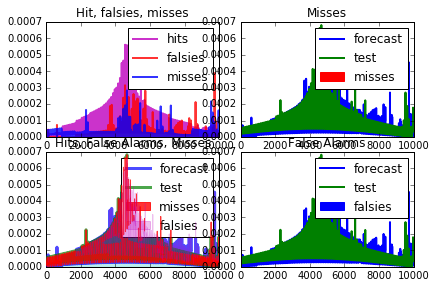

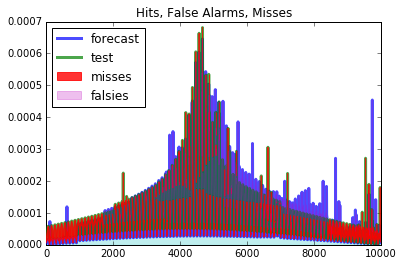

In [16]:
AA=etas_analyzer.roc_gs_linear_figs(diffs)

In [14]:
print(diffs[0:10])

[ (5.691646505044295e-06, 1.9362799236864667e-05, -1.3671152731820372e-05, 5.691646505044295e-06, 1.3671152731820372e-05, 0.0)
 (6.1267210019227395e-06, 2.0419330119280936e-05, -1.4292609117358198e-05, 6.1267210019227395e-06, 1.4292609117358198e-05, 0.0)
 (6.559801637531696e-06, 2.147144008026976e-05, -1.4911638442738064e-05, 6.559801637531696e-06, 1.4911638442738064e-05, 0.0)
 (6.9967956309166016e-06, 2.25187816165285e-05, -1.55219859856119e-05, 6.9967956309166016e-06, 1.55219859856119e-05, 0.0)
 (7.457733067967209e-06, 2.3560994984362362e-05, -1.6103261916395153e-05, 7.457733067967209e-06, 1.6103261916395153e-05, 0.0)
 (8.014528469022635e-06, 2.459770799046625e-05, -1.6583179521443616e-05, 8.014528469022635e-06, 1.6583179521443616e-05, 0.0)
 (8.682983845670213e-06, 2.5628535799834943e-05, -1.6945551954164728e-05, 8.682983845670213e-06, 1.6945551954164728e-05, 0.0)
 (8.850176351478811e-06, 2.6653080763319593e-05, -1.780290441184078e-05, 8.850176351478811e-06, 1.780290441184078e-05, 0.

In [15]:
print(z2[0:10])

[  1.93627992e-05   2.04193301e-05   2.14714401e-05   2.25187816e-05
   2.35609950e-05   2.45977080e-05   2.56285358e-05   2.66530808e-05
   2.76709323e-05   2.86816666e-05]


In [11]:
zz=etas_test.ETAS_array['z'].copy()
print(zz[0:10])

[  2.78477525e-06   2.81961763e-06   2.85474741e-06   2.89015268e-06
   2.92582046e-06   2.96173671e-06   2.99788620e-06   3.03425254e-06
   3.07081813e-06   3.10756406e-06]
